In [2]:
import xlfluor as xlf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import lmfit
import pandas as pd

global DEBUG
DEBUG = True

%matplotlib notebook

## Defining the Cavity

In [3]:
vacuum = xlf.Vacuum()
carbon = xlf.Element(name = 'c', Z= 6, atom_weight = 12.011,density = 2.2*1e3) # the factor 1e3 converts from g/cm3 to Kg/m3
silicon = xlf.Element(name = 'si', Z= 14, atom_weight = 28.086,density = 2.33*1e3)
iron = xlf.Element(name = 'fe', Z = 26, atom_weight=55.845, density=7.87*1e3)
oxygen = xlf.Element(name = 'o', Z = 8, atom_weight=15.999, density=0.143E-02*1e3) # Oxygen density is as gas!!
platinum = xlf.Element(name = 'pt', Z = 78, atom_weight=195.078, density=21.5*1e3)

iron_oxide = xlf.Composite(name = 'fe2o3', elements=[iron, oxygen], density=5.07*1e3, composition =[2,3])

layer_list_custom = [
    xlf.Layer(platinum, 2.8 * 1e-9, density=21.0e3),
    xlf.Layer(carbon, 31.26 * 1e-9, density=1.7e3),
    xlf.Layer(iron_oxide, 3.9 * 1e-9, inelastic_cross=0.4e9, density=4.5e3),
    xlf.Layer(carbon, 34.136 * 1e-9, density=1.6e3),
    xlf.Layer(platinum, 15 * 1e-9, density=21.00e3),
    xlf.Layer(silicon, np.inf, density = 2.33*1e3, final = True)
]
layer_list_custom2 = [
    xlf.Layer(platinum, 1.755 * 1e-9, density=20.5e3),
    xlf.Layer(carbon, 31.26 * 1e-9, density=1.656e3),
    xlf.Layer(iron_oxide, 3.9 * 1e-9, inelastic_cross=0.4e9, density=4.309e3),
    xlf.Layer(carbon, 34.136 * 1e-9, density=1.589e3),
    xlf.Layer(platinum, 15 * 1e-9, density=20.50e3),
    xlf.Layer(silicon, np.inf, density = 2.614*1e3, final = True)
]

cavity = xlf.Cavity(layer_list_custom2)



pt Layer Initiated.
c Layer Initiated.
fe2o3 Layer Initiated.
c Layer Initiated.
pt Layer Initiated.
si Layer Initiated.
pt Layer Initiated.
c Layer Initiated.
fe2o3 Layer Initiated.
c Layer Initiated.
pt Layer Initiated.
si Layer Initiated.
Cavity Initiated.


## Loading Experimental Data for Fitting

In [4]:

#### Let us read some experimental data for comparison
keys = ['dt', 'dtz', 'fluor_diode', 'izero_diode', 'refl', 'scanNr',
       'sry', 'sty']
loaded_scan_mat = np.loadtxt('scan_486_wide_angle_diode.txt')
loaded_scan = {}
for i, key in enumerate(keys):
    loaded_scan[key] = loaded_scan_mat[1:,i]

experiment_data = {
    'fluor_diode': xlf.normmax(loaded_scan['fluor_diode']),
    'refl': xlf.normmax(loaded_scan['refl']),
    'angles_in': np.array(loaded_scan['sry']),
    'energies_out': np.array([6400])
}


##### Accounting for experimental offset
# In this dataset it appears that the "sry" motor was offset by 0.025°
experiment_data['angles_in'] = xlf.deg2rad(experiment_data['angles_in'] - 0.025)

## Define Axes
The axis defined here will only be regarded if the same axes are not specified in the experiment data.

In [5]:

energies_in=np.array([7150])
energies_out=np.array([6400])
angles_in  = np.linspace(xlf.deg2rad(0.2),xlf.deg2rad(1.0),100) #np.array([xlf.deg2rad(0.3)])#
angles_out = np.linspace(xlf.deg2rad(0.2),xlf.deg2rad(1.0),100) #np.array(xlf.deg2rad(np.array([0.2,0.3])))#

axes = {'energies_in': energies_in,
        'energies_out': energies_out,
        'angles_in': angles_in,
        'angles_out':angles_out}

## Instantiate Problem and parameters

In [6]:
# Construc the problem object
my_problem = xlf.Problem(cavity, experiment_data = experiment_data, axes=axes,\
                         passive_layer_resolution = 3, active_layer_resolution = 3)

# Get a set of parameters based on the layer list defined above
parameters = cavity.parameters

# Calculate an initial solution
my_problem.solve(cavity, parameters)

# Get the relative intensities of fluorescence and reflectivity
cavity.get_relative_intensities(my_problem)

cavity.set_fit_weigths(weight_refl = 1, weight_fluor = 2)


Layer 0 Solution Calculated.
Layer 1 Solution Calculated.
Layer 2 Solution Calculated.
Layer 3 Solution Calculated.
Layer 4 Solution Calculated.
Layer 5 Solution Calculated.
ProblemSolution Initiated.
Based on the Initial fit, setting relative intensity of refl and fluor 
 to 0.9285467215887053 and 0.005403902252621292, respectively


<IPython.core.display.Javascript object>


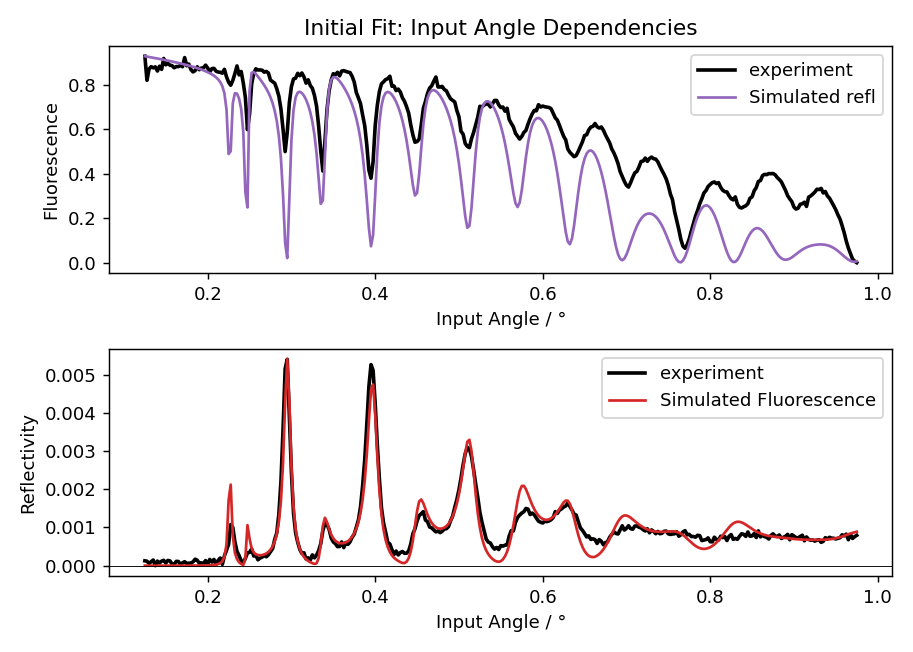

In [7]:
###################################################
##### Diode trace plots
###################################################
angles_in = xlf.rad2deg(my_problem.angles_in)
model_fluor = xlf.abs2(my_problem.fluorescence_I_angle_in_dependent)
model_refl = np.mean(xlf.abs2(my_problem.reflectivity),0)

exp_fluor = my_problem.experiment['fluor_diode']*cavity.parameters['I_fluorescence']
exp_refl = my_problem.experiment['refl']*cavity.parameters['I_reflectivity']

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7, 5))
ax1.set_title(f'Initial Fit: Input Angle Dependencies')

plt.sca(ax1)
ax1.plot(angles_in, exp_refl, c='k', lw=2,label = 'experiment')
ax1.plot(angles_in, model_refl, 'C4-', label='Simulated refl')

plt.ylabel('Normalized Intensity / arb. u.')
plt.xlabel('Input Angle / °')
plt.ylabel('Fluorescence')
plt.legend()

plt.sca(ax2)
ax2.plot(angles_in, exp_fluor, c='k', lw=2,label = 'experiment')
ax2.plot(angles_in, model_fluor, c='C3',
         label='Simulated Fluorescence')
plt.xlabel('Input Angle / °')
plt.legend()
plt.ylabel('Reflectivity')
plt.axhline(c='k', lw=.5)
plt.tight_layout()


## Optimization

### Create the logger for following fit parameters and plotting

<IPython.core.display.Javascript object>


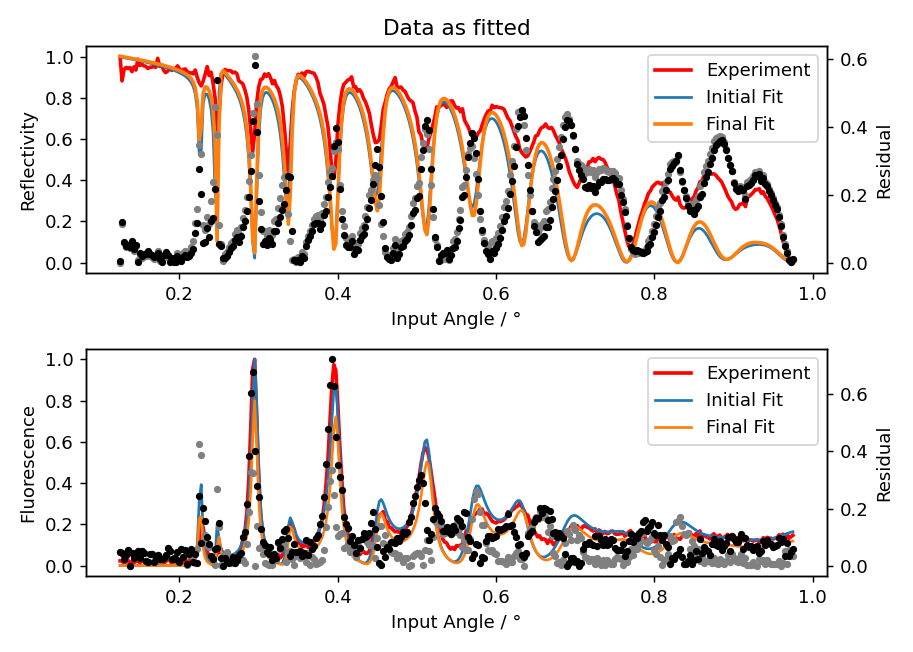

<IPython.core.display.Javascript object>


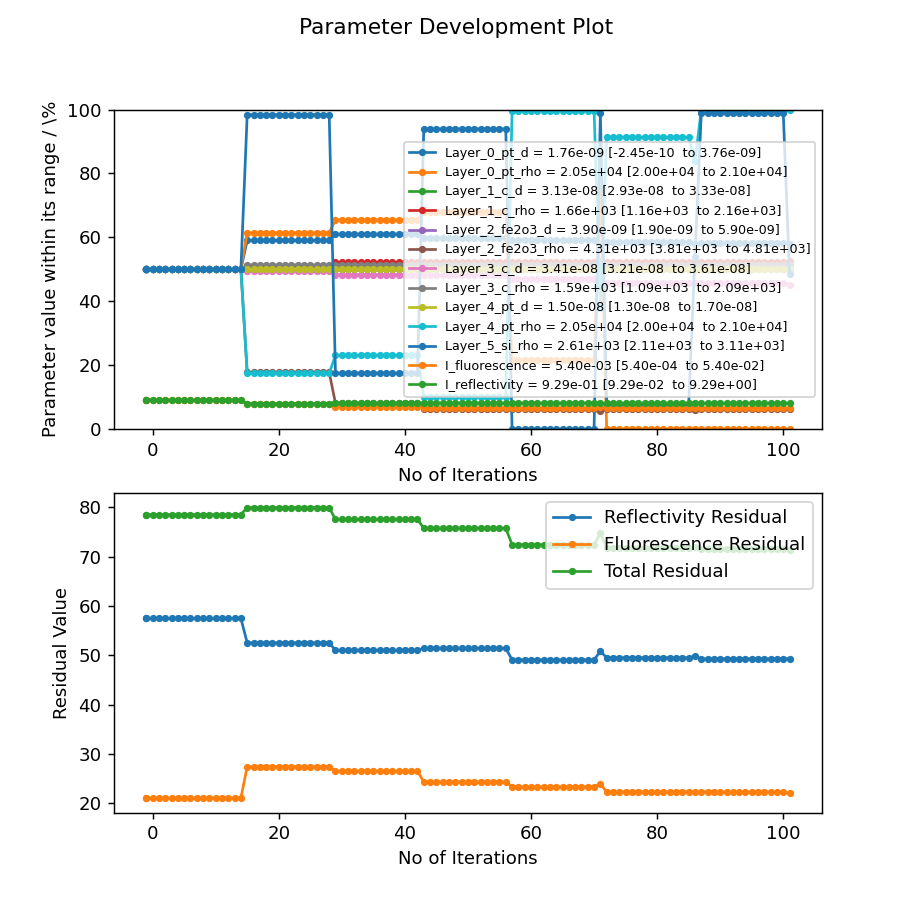

In [11]:
        
logger = xlf.FitLogger(my_problem, parameters, maxiter = 100)

### Run a minimizer on the cost function

In [12]:
minimizer = lmfit.Minimizer(xlf.cost_function, params=parameters,\
                            fcn_args= (my_problem,),\
                            iter_cb = logger.logging)#xlf.fit_monitoring

result = minimizer.minimize(method = 'leastsq')#

lmfit.report_fit(result)
plt.show()

{'Refl': 57.46110554896764, 'Fluor': 21.05282952535444}
Iteration -1 complete. Residuals: {'Refl': 57.46110554896764, 'Fluor': 21.05282952535444}
{'Refl': 57.46110554896764, 'Fluor': 21.05282952535444}
Iteration 0 complete. Residuals: {'Refl': 57.46110554896764, 'Fluor': 21.05282952535444}
{'Refl': 57.46110554896764, 'Fluor': 21.05282952535444}
Iteration 1 complete. Residuals: {'Refl': 57.46110554896764, 'Fluor': 21.05282952535444}
{'Refl': 57.46110528957031, 'Fluor': 21.05282905951622}
Iteration 2 complete. Residuals: {'Refl': 57.46110528957031, 'Fluor': 21.05282905951622}
{'Refl': 57.46110554066171, 'Fluor': 21.052829521458087}
Iteration 3 complete. Residuals: {'Refl': 57.46110554066171, 'Fluor': 21.052829521458087}
{'Refl': 57.46110554896764, 'Fluor': 21.05282952535444}
Iteration 4 complete. Residuals: {'Refl': 57.46110554896764, 'Fluor': 21.05282952535444}
{'Refl': 57.46110546593119, 'Fluor': 21.052826901063817}
Iteration 5 complete. Residuals: {'Refl': 57.46110546593119, 'Fluor': 

Layer 2 Solution Calculated.
{'Refl': 51.41918271480206, 'Fluor': 24.33747625577613}
Iteration 49 complete. Residuals: {'Refl': 51.41918271480206, 'Fluor': 24.33747625577613}
Layer 3 Solution Calculated.
{'Refl': 51.41918272079768, 'Fluor': 24.337476295808415}
Iteration 50 complete. Residuals: {'Refl': 51.41918272079768, 'Fluor': 24.337476295808415}
Layer 3 Solution Calculated.
{'Refl': 51.41918271139342, 'Fluor': 24.337476281627175}
Iteration 51 complete. Residuals: {'Refl': 51.41918271139342, 'Fluor': 24.337476281627175}
{'Refl': 51.41918271575708, 'Fluor': 24.337476278140848}
Iteration 52 complete. Residuals: {'Refl': 51.41918271575708, 'Fluor': 24.337476278140848}
Layer 4 Solution Calculated.
{'Refl': 51.41918293844016, 'Fluor': 24.337476265695845}
Iteration 53 complete. Residuals: {'Refl': 51.41918293844016, 'Fluor': 24.337476265695845}
Layer 5 Solution Calculated.
{'Refl': 51.41918271161425, 'Fluor': 24.337476295032385}
Iteration 54 complete. Residuals: {'Refl': 51.41918271161425

{'Refl': 49.2813439488945, 'Fluor': 22.26060514871388}
Iteration 94 complete. Residuals: {'Refl': 49.2813439488945, 'Fluor': 22.26060514871388}
Layer 3 Solution Calculated.
{'Refl': 49.28134393863256, 'Fluor': 22.260605106132207}
Iteration 95 complete. Residuals: {'Refl': 49.28134393863256, 'Fluor': 22.260605106132207}
{'Refl': 49.28134394197177, 'Fluor': 22.260605132786715}
Iteration 96 complete. Residuals: {'Refl': 49.28134394197177, 'Fluor': 22.260605132786715}
Layer 4 Solution Calculated.
{'Refl': 49.28134394892954, 'Fluor': 22.260605130431998}
Iteration 97 complete. Residuals: {'Refl': 49.28134394892954, 'Fluor': 22.260605130431998}
Layer 5 Solution Calculated.
{'Refl': 49.2813439402763, 'Fluor': 22.260605135756713}
Iteration 98 complete. Residuals: {'Refl': 49.2813439402763, 'Fluor': 22.260605135756713}
{'Refl': 49.28134394197177, 'Fluor': 22.26060507982434}
Iteration 99 complete. Residuals: {'Refl': 49.28134394197177, 'Fluor': 22.26060507982434}
{'Refl': 49.281342368179395, 'Flu

In [13]:
logger.final_plot()

<IPython.core.display.Javascript object>


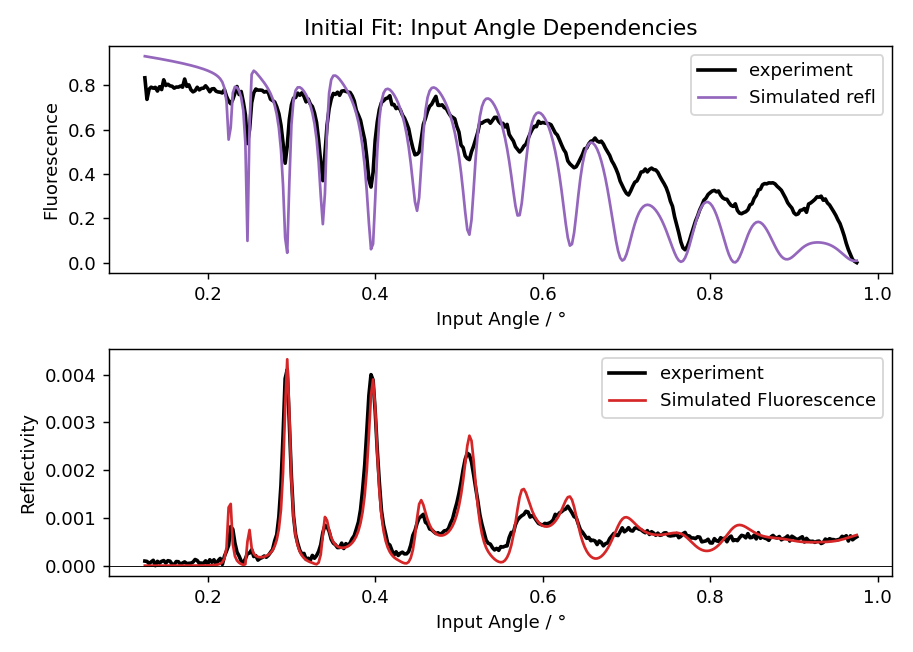

In [14]:
###################################################
##### Diode trace plots
###################################################
angles_in = xlf.rad2deg(my_problem.angles_in)
model_fluor = xlf.abs2(my_problem.fluorescence_I_angle_in_dependent)
model_refl = np.mean(xlf.abs2(my_problem.reflectivity),0)

exp_fluor = my_problem.experiment['fluor_diode']*cavity.parameters['I_fluorescence']
exp_refl = my_problem.experiment['refl']*cavity.parameters['I_reflectivity']

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7, 5))
ax1.set_title(f'Initial Fit: Input Angle Dependencies')

plt.sca(ax1)
ax1.plot(angles_in, exp_refl, c='k', lw=2,label = 'experiment')
ax1.plot(angles_in, model_refl, 'C4-', label='Simulated refl')

plt.ylabel('Normalized Intensity / arb. u.')
plt.xlabel('Input Angle / °')
plt.ylabel('Fluorescence')
plt.legend()

plt.sca(ax2)
ax2.plot(angles_in, exp_fluor, c='k', lw=2,label = 'experiment')
ax2.plot(angles_in, model_fluor, c='C3',
         label='Simulated Fluorescence')
plt.xlabel('Input Angle / °')
plt.legend()
plt.ylabel('Reflectivity')
plt.axhline(c='k', lw=.5)
plt.tight_layout()


<IPython.core.display.Javascript object>


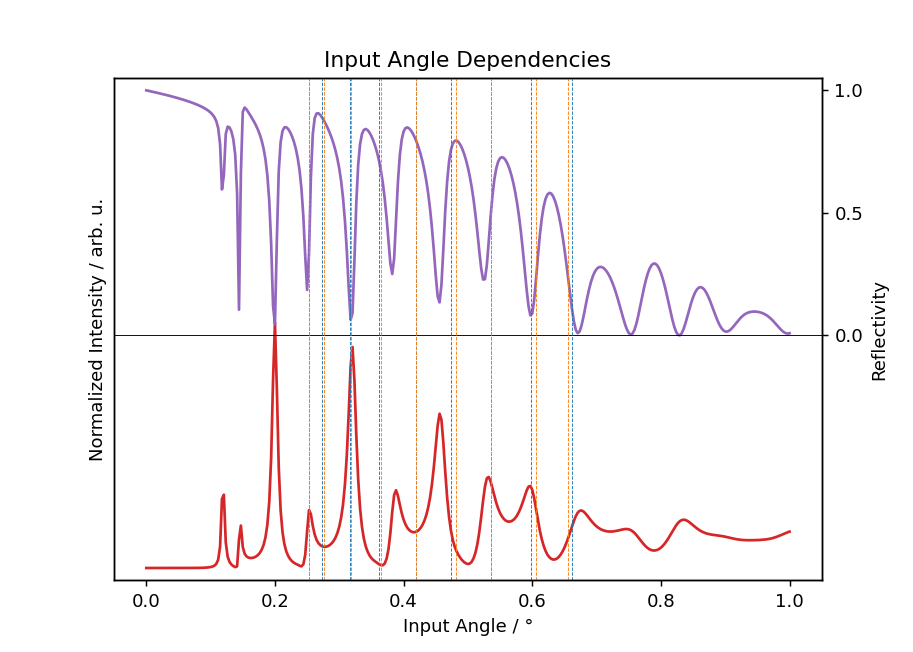

In [15]:



###################################################
##### Diode trace plots
###################################################
plt.figure(figsize=(7, 5))
ax1 = plt.gca()
plt.ylabel('Normalized Intensity / arb. u.')
plt.plot(xlf.normmax(my_problem.angles_in), xlf.abs2(my_problem.reflectivity)[0,:] * np.nan, 'C4-',
         label='Simulated Reflectivity')  # dummy plots for legend
plt.plot(xlf.normmax(my_problem.angles_in), xlf.abs2(my_problem.reflectivity)[0,:] * np.nan, 'C0--',
         label='Measured Reflectivity')

plt.plot(xlf.normmax(my_problem.angles_in), xlf.normmax(xlf.abs2(my_problem.fluorescence_I_angle_in_dependent)), c='C3',
         label='Simulated Fluorescence')
data_shift = 0

# plt.ylim(None,6)
plt.xlabel('Input Angle / °')
plt.title(f'Input Angle Dependencies')
plt.yticks([])
plt.ylim(None, 2)

ax2 = plt.gca().twinx()
plt.plot(xlf.normmax(my_problem.angles_in), xlf.normmax(xlf.abs2(my_problem.reflectivity)[0,:]), 'C4-', label='Simulated refl')
plt.ylabel('Reflectivity')
plt.ylim(-1, None)
plt.yticks([0, 0.5, 1])
plt.axhline(c='k', lw=.5)

mode_angles = [.253, .2725, .317, .3625, .420, .474, .536, .598, .662]
for angle in mode_angles:
    plt.axvline(angle - data_shift, lw=.5, c='C0', ls='--')
mode_angles = [.253, .276, .318, .365, .420, .482, .536, .606, .655]
for angle in mode_angles:
    plt.axvline(angle - data_shift, lw=.5, c='C1', ls='--')




In [16]:
cavity.solution.incident_field_amplitude.shape

(1, 341, 18)

<IPython.core.display.Javascript object>


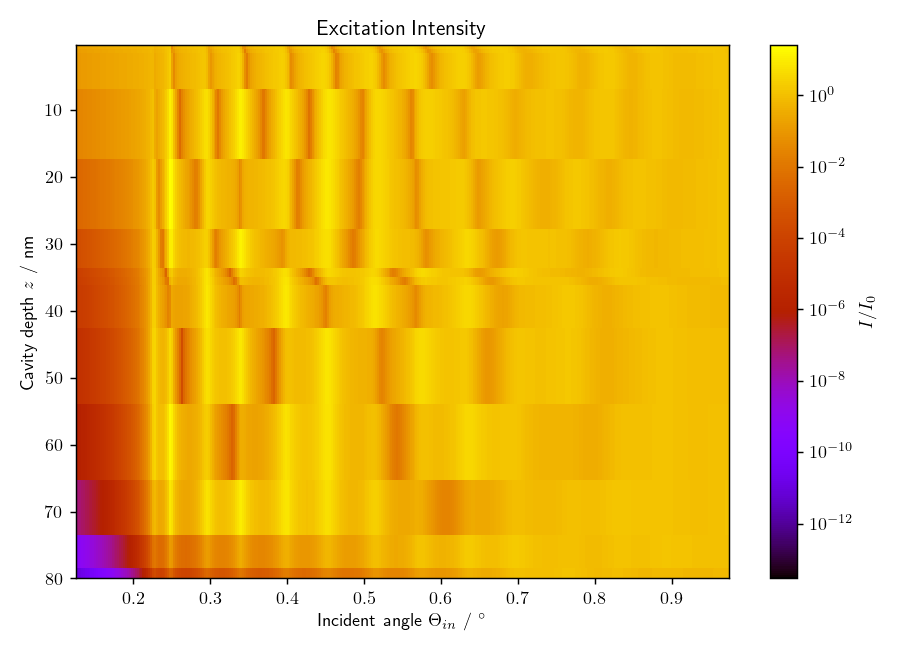

(80.0, 0.29250000000000004)

In [17]:

mpl.rcParams['text.usetex'] = True

plt.figure(figsize = (7,5))
plt.pcolormesh(xlf.rad2deg(my_problem.angles_in),my_problem.z_axis*1e9, xlf.abs2(cavity.solution.incident_field_amplitude[0,:,:]).T,\
               cmap = 'gnuplot', norm = mpl.colors.LogNorm(),shading = 'nearest')

plt.ylabel('Cavity depth $z$ / nm')
plt.xlabel('Incident angle $ { \Theta}_{in}$ / $^\circ$')
plt.title('Excitation Intensity')
plt.colorbar(label='$I / I_0$')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.ylim(80,None)


<IPython.core.display.Javascript object>


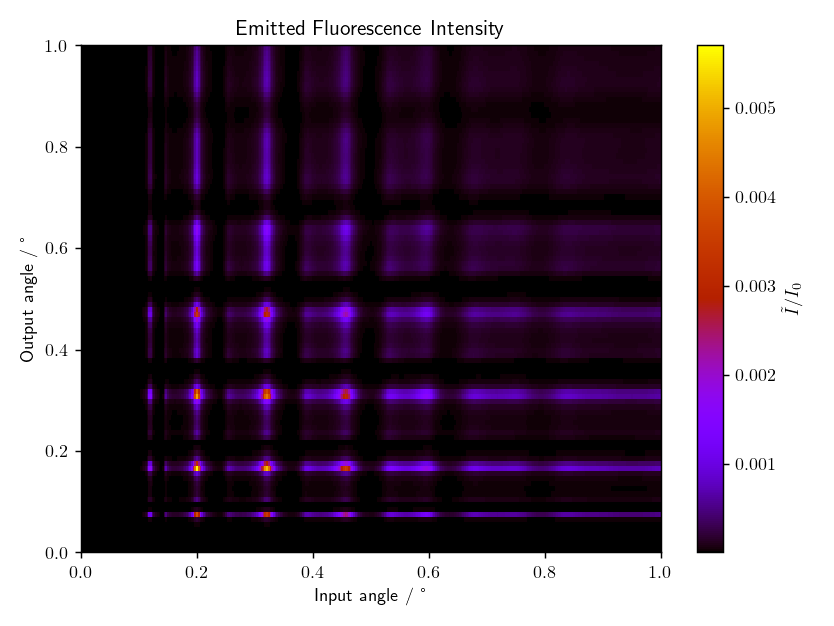

<IPython.core.display.Javascript object>


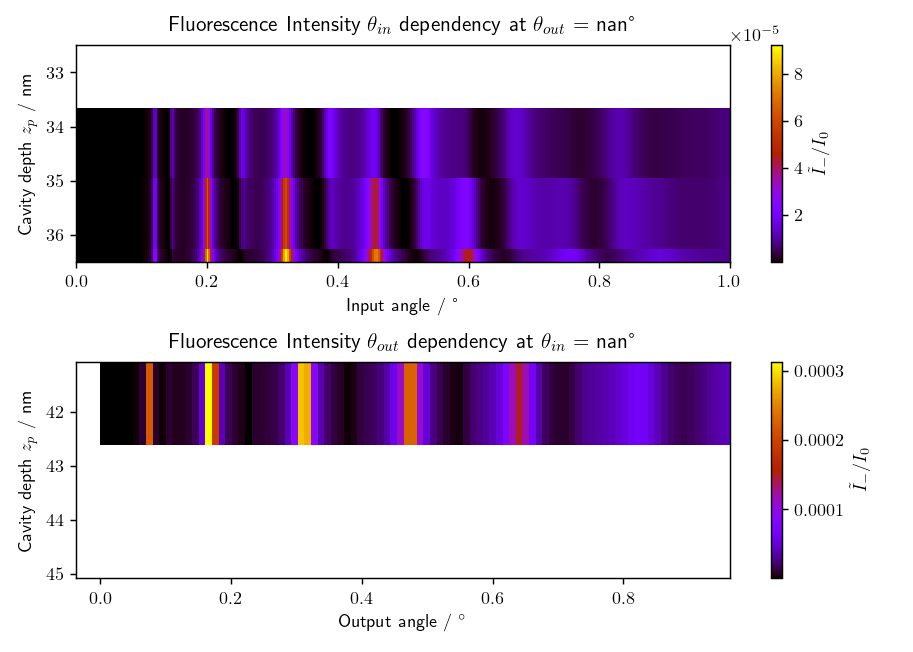

In [27]:


#####################################################
######### 2d Plot
################################################
plotmat = xlf.abs2(cavity.solution.fluorescence_emitted_amplitude[0,0,:,:])
#plotmat = xlf.abs2(np.nansum(cavity.solution.fluorescence_local_amplitude[0,0,:,:,:,0],2)) # sum over depth of non-propagated fluorescence
#plotmat = cplxsq(my_problem.fluor_emitted_from_z[:,:,:])
#plotmat = cplxsq(np.sum(my_problem.fluor_emitted_from_z[:,:,:],0))

plt.figure()
plt.pcolormesh(xlf.normmax(my_problem.angles_in),xlf.normmax(my_problem.angles_out),\
               plotmat.T, cmap = 'gnuplot', shading = 'nearest')#,vmax=4e3)#norm = mpl.colors.LogNorm(vmin = 0.005),
plt.ylabel('Output angle / °')
plt.xlabel('Input angle / °')
plt.title('Emitted Fluorescence Intensity')
plt.colorbar(label=r'$\tilde{I} / I_0$')
plt.tight_layout()


#########################################


example_angle_in = xlf.deg2rad(0.3)
example_angle_in_index = np.argmin(np.abs(example_angle_in-my_problem.angles_in))

example_angle_out = xlf.deg2rad(0.342)
example_angle_out_index = np.argmin(np.abs(example_angle_out-my_problem.angles_out))



fig, axes = plt.subplots(2,1, figsize = (7,5))
plt.sca(axes[0])
plt.pcolormesh(xlf.normmax(my_problem.angles_in),my_problem.z_axis*1e9,\
               xlf.abs2(cavity.solution.fluorescence_local_amplitude_propagated[0,0,:,example_angle_out_index,:]).T,shading = 'nearest',cmap = 'gnuplot')
plt.axvline(xlf.normmax(example_angle_in), ls = '--', lw= 1, c='grey')

plt.ylabel('Cavity depth $z_p$ / nm')
plt.xlabel('Input angle / °')
plt.title(r'Fluorescence Intensity $\theta_{in}$ dependency at $\theta_{out}$ ='+f' {xlf.normmax(my_problem.angles_out[example_angle_out_index]):.2}°')
plt.colorbar(label=r'$\tilde{I}_{-} / I_0$')
plt.gca().invert_yaxis()
plt.ylim(32.5,36.5)
plt.tight_layout()
plt.gca().invert_yaxis()

plt.sca(axes[1])
plt.pcolormesh(xlf.normmax(my_problem.angles_out),my_problem.z_axis*1e9,\
               xlf.abs2(cavity.solution.fluorescence_local_amplitude_propagated[0,0,example_angle_in_index,:,:]).T,shading = 'nearest', vmax=None,cmap = 'gnuplot')#, norm = mpl.colors.LogNorm()
plt.axvline(xlf.normmax(example_angle_out), ls = '--', lw= 1, c='grey')
plt.ylabel('Cavity depth $z_p$ / nm')
plt.xlabel('Output angle / $^\circ$')
plt.title(r'Fluorescence Intensity $\theta_{out}$ dependency at $\theta_{in}$ ='+f' {xlf.normmax(my_problem.angles_in[example_angle_in_index]):.2}°')
plt.colorbar(label=r'$\tilde{I}_{-} / I_0$')
plt.gca().invert_yaxis()
plt.ylim(32.5,36.5)
plt.tight_layout()
plt.gca().invert_yaxis()



plt.show()